In [2]:
# Install required libaries
!pip install tweepy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install numpy
!pip install gensim
!pip install seaborn
!pip install bokeh
!pip install pyldavis==2.1.2
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=8d9d7945bf0c4dc0a22a1cafdaf3a6775efaca72bbd1625577b3b9d7a0c309c6
  Stored in directory: c:\users\shefa\appdata\local\pip\cache\wheels\31\8c\a0\24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
Successfully built pyldavis


2021-03-29 19:12:18.936832: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-03-29 19:12:18.937750: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.stem.porter import *
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import os.path
import tweepy
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shefa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Questions we are looking to answer about the Farmers Protest in India:
1) General sentiments of people - are they in favour of the Farm Bill or not - Classification. <br>
2) What are their main concerns - NER

## Set up config information

In [3]:
# CSV Names
RAW_CSV_NAME = "raw_tweets.csv"
PREPROCESSED_CSV_NAME = "preprocessed_tweets.csv"

# Twitter API Credentials
CONSUMER_KEY = "hnGPJx6xBsudTgwOAxd0UNGUW"
CONSUMER_SECRET = "JcxhisQeF19hlEHRdeBifU3aL4R9DP9BWEMjYJ7MtnGcWaxn0p"
ACCESS_KEY = "1249286455530123264-5LbTPxHcE8Hl3CHhWztOsycMGEViHT"
ACCESS_SECRET = "4vdHhFP3odtZSUAKkK6GgPm7Vl03EHwvbP7cRTLFmQbFf"

pd.set_option('display.max_colwidth', -1)

<ipython-input-3-417303d6515a>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Load Tweets

In [4]:
USE_OLD_CSV = True

if not USE_OLD_CSV or not os.path.isfile(RAW_CSV_NAME):
    # Connect to API
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # Query the API
    search_term = "FarmersProtest"
    max_items = 5000
    result_type = "recent"
    lang = "en"
    # Do not include retweets, ensure tweet has 1 minimum retweet and is after September 2020        
    response = tweepy.Cursor(api.search, q=search_term+"-filter:retweets min_retweets:1 since:2020-09-01",
                             result_type=result_type, lang=lang, tweet_mode="extended").items(max_items)

    # Extract only the required keys from the response
    tweets = [
        [tweet.created_at,
         tweet.full_text,
         tweet.retweet_count,
         tweet.favorite_count,
         tweet.user.screen_name,
         tweet.user.followers_count,
         tweet.user.verified
        ] for tweet in response]

    # Store as CSV for later
    tweets_df = pd.DataFrame(data=tweets, columns=["created_at", "text", "retweet_count", "favorite_count",
    "user_screen_name", "user_followers_count", "user_verified"])
    tweets_df.to_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

raw_tweets = pd.read_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8')

## Preprocessing

In [5]:
tweets_df = raw_tweets.copy()
tweets_df['text_processed'] = raw_tweets['text']

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove any hashtags
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
# min_word_length = 3
# tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
print(processed_tweets_df['text_processed'].head())
processed_tweets_df.to_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

0    Proud moment for us congratulations \rugraha ji and Tikat sir                                                                                                                                                                  
1    UPDATE Bapu Sukhdev Singh ji has been released from jail Bapu Ji with our legal team Panjaab Lawyers Senior Advocate Paramjeet Singh \r\rFull video from todays release \r\r \r\r\r\r\r\r                                      
2    Found this one on Instragram page of SaffronStudios page \r \r                                                                                                                                                                 
3    The country is proud of Punjabis The people who are still protesting against your stupid laws \r\rHad people protested during Demonetization /GST and all these 7 years we wouldnt have seen this India \r\rBravo Punjabis \r\r
4    What a poetic message to Modi Gov\r\r                                          

 ## Word Cloud

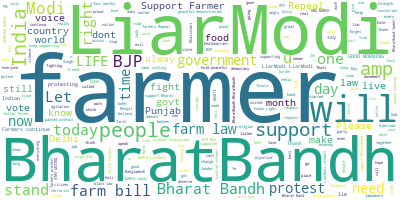

In [7]:
processed_tweets_df = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')

# join the words of the different tweets together into one string
long_string = ' '.join([text for text in processed_tweets_df['text_processed']])
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

# Topic Modelling

In [25]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# Do you want to modify this by adding more stop words?
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]


data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]


/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
from pprint import pprint

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.028*"farmers" + 0.025*"liarmodi" + 0.019*"bharatbandh" + 0.014*"farm" + '
  '0.010*"support" + 0.008*"repeal" + 0.008*"modi" + 0.007*"india" + '
  '0.007*"peaceful" + 0.006*"continue"'),
 (1,
  '0.034*"farmers" + 0.020*"liarmodi" + 0.019*"support" + 0.011*"india" + '
  '0.011*"bharatbandh" + 0.008*"bjp" + 0.007*"amp" + 0.007*"save" + '
  '0.007*"life" + 0.007*"good"'),
 (2,
  '0.015*"people" + 0.015*"amp" + 0.012*"farmers" + 0.011*"bharatbandh" + '
  '0.009*"liarmodi" + 0.008*"laws" + 0.007*"farm" + 0.007*"bjp" + '
  '0.006*"india" + 0.006*"bharat"'),
 (3,
  '0.047*"farmers" + 0.018*"bharatbandh" + 0.016*"liarmodi" + 0.013*"support" '
  '+ 0.009*"bharat" + 0.008*"today" + 0.008*"modi" + 0.007*"country" + '
  '0.006*"farm" + 0.006*"govt"'),
 (4,
  '0.025*"liarmodi" + 0.015*"farmers" + 0.010*"bharatbandh" + 0.009*"india" + '
  '0.006*"protest" + 0.005*"people" + 0.005*"amp" + 0.005*"right" + '
  '0.004*"support" + 0.004*"keep"')]


### What is the Dominant topic and its percentage contribution in each document

In [27]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9087,"farmers, liarmodi, bharatbandh, farm, support, repeal, modi, india, peaceful, continue","[proud, moment, us, congratulations, ugraha, ji, tikat, sir]"
1,1,2.0,0.9632,"people, amp, farmers, bharatbandh, liarmodi, laws, farm, bjp, india, bharat","[update, bapu, sukhdev, singh, ji, released, jail, bapu, ji, legal, team, panjaab, lawyers, senior, advocate, paramjeet, singh, full, video, todays, release]"
2,2,0.0,0.8835,"farmers, liarmodi, bharatbandh, farm, support, repeal, modi, india, peaceful, continue","[found, one, instragram, page, saffronstudios, page]"
3,3,3.0,0.9565,"farmers, bharatbandh, liarmodi, support, bharat, today, modi, country, farm, govt","[country, proud, punjabis, people, still, protesting, stupid, laws, people, protested, demonetization, gst, years, wouldnt, seen, india, bravo, punjabis]"
4,4,0.0,0.8373,"farmers, liarmodi, bharatbandh, farm, support, repeal, modi, india, peaceful, continue","[poetic, message, modi, gov]"
5,5,0.0,0.8265,"farmers, liarmodi, bharatbandh, farm, support, repeal, modi, india, peaceful, continue","[europe, please, advise, world, health, organisation, certified, products, brand, actually, work]"
6,6,2.0,0.7287,"people, amp, farmers, bharatbandh, liarmodi, laws, farm, bjp, india, bharat","[action, reaction]"
7,7,0.0,0.9188,"farmers, liarmodi, bharatbandh, farm, support, repeal, modi, india, peaceful, continue","[farmers, require, prices, moderate, markets, steady, reason, need, msp]"
8,8,2.0,0.8358,"people, amp, farmers, bharatbandh, liarmodi, laws, farm, bjp, india, bharat","[kaur, sohal, beautifully, written]"
9,9,4.0,0.9365,"liarmodi, farmers, bharatbandh, india, protest, people, amp, right, support, keep","[thanks, everyone, follow, special, thanks, mare, vere, nu, god, bless, farmers, supporters]"


### The most representative sentence for each topic

In [28]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9739,"farmers, liarmodi, bharatbandh, farm, support, repeal, modi, india, peaceful, continue","[cut, electricity, state, govt, dont, fulfill, demand, rakesh, tikait, aisa, mat, karna, andhere..."
1,1.0,0.9802,"farmers, liarmodi, support, india, bharatbandh, bjp, amp, save, life, good","[ik, bjp, leader, de, shittar, parade, ton, baad, lokan, te, case, kar, ditta, jehre, saade, res..."
2,2.0,0.9762,"people, amp, farmers, bharatbandh, liarmodi, laws, farm, bjp, india, bharat","[khalistani, word, giveb, tag, terr, rists, wrong, amp, nvr, got, rectifiedkhalsa, means, pure, ..."
3,3.0,0.9709,"farmers, bharatbandh, liarmodi, support, bharat, today, modi, country, farm, govt","[ofcourse, farmers, marched, towards, delhi, different, agenda, bills, msp, anybody, wants, talk..."
4,4.0,0.9727,"liarmodi, farmers, bharatbandh, india, protest, people, amp, right, support, keep","[bjp, leaders, parveen, bansal, along, barnala, chief, yadwinder, shanty, barnala, charge, vijay..."


### Frequency Distribution of Word Counts in Documents

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


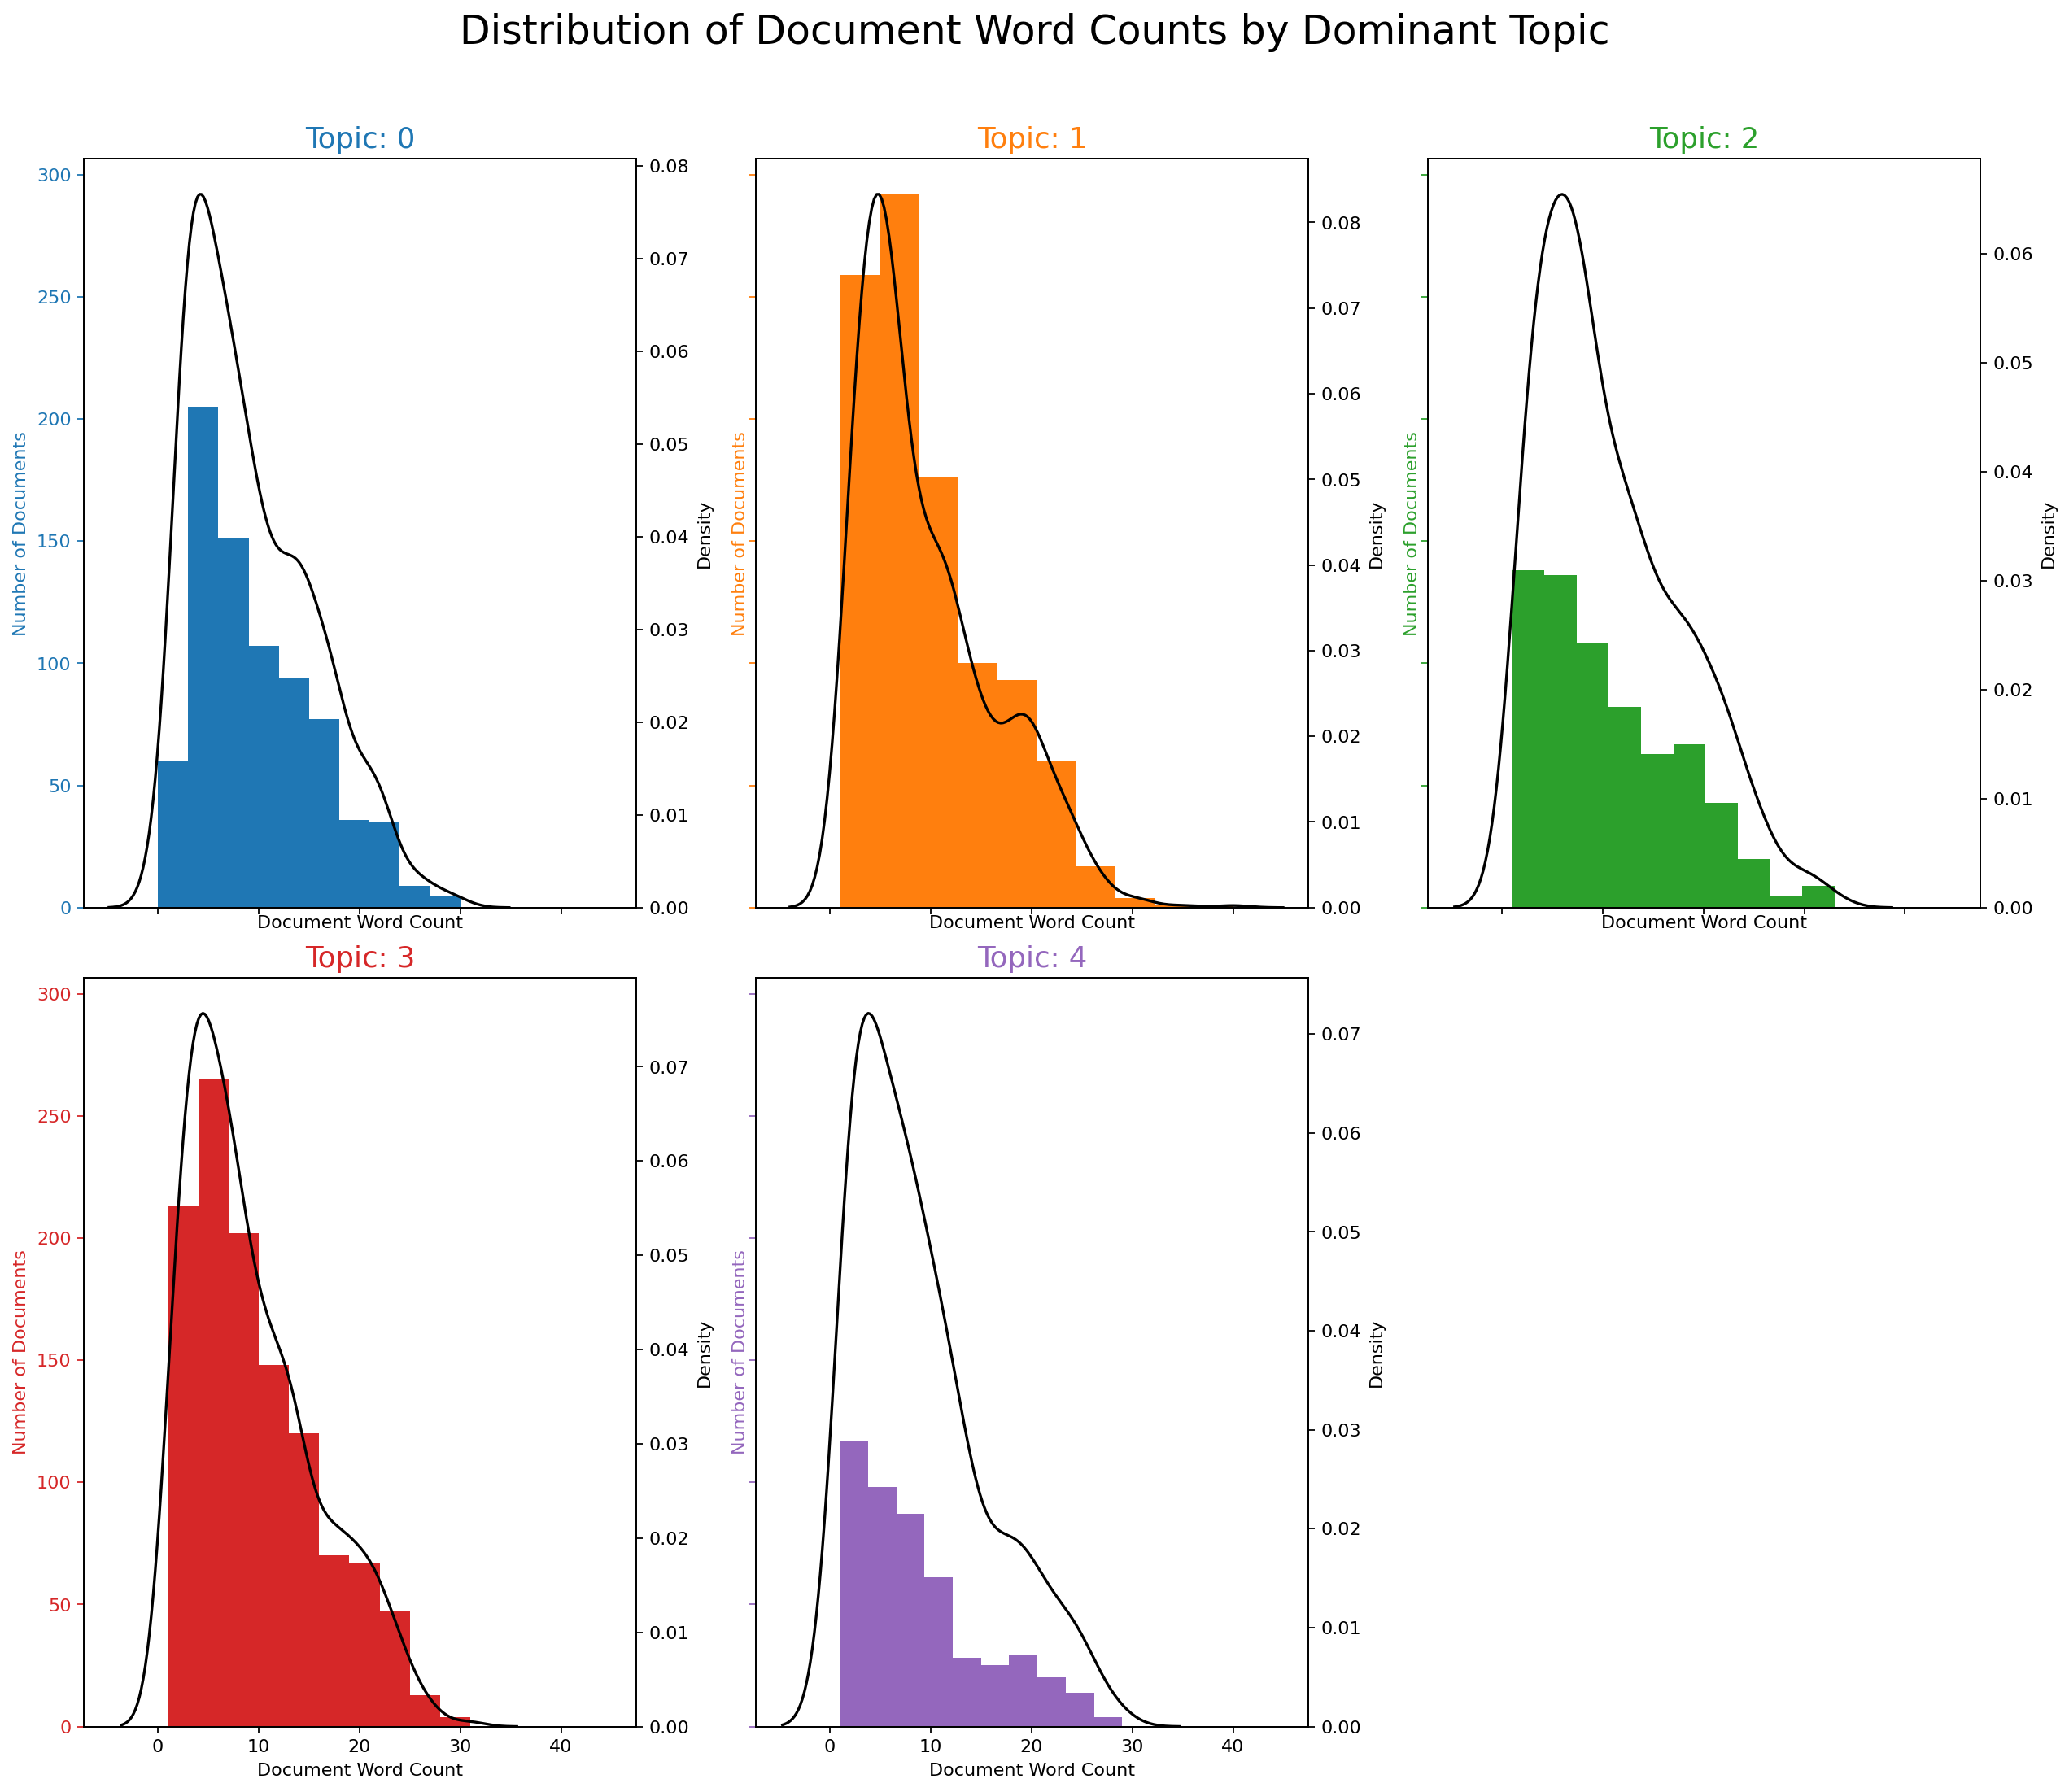

In [29]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):  
    if i<num_topics:
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
        ax.set(xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))
    else:
        ax.set_visible(False)

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


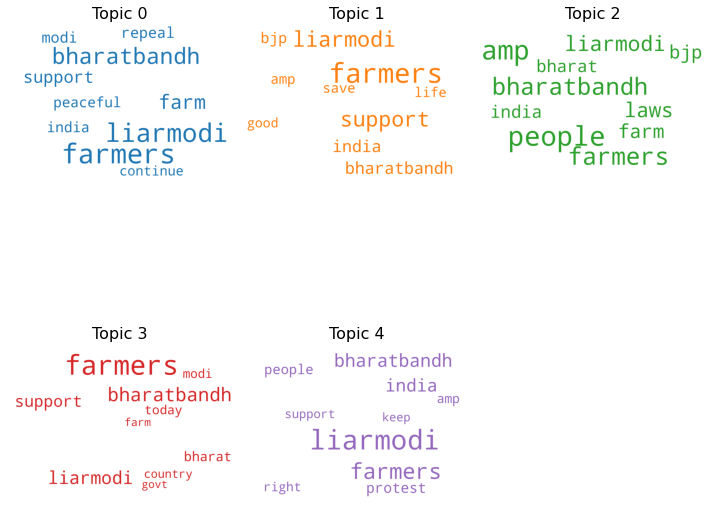

In [30]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(topics):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    else:
        ax.set_visible(False)


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-31-5db36dac2dd8>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-31-5db36dac2dd8>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-31-5db36dac2dd8>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')

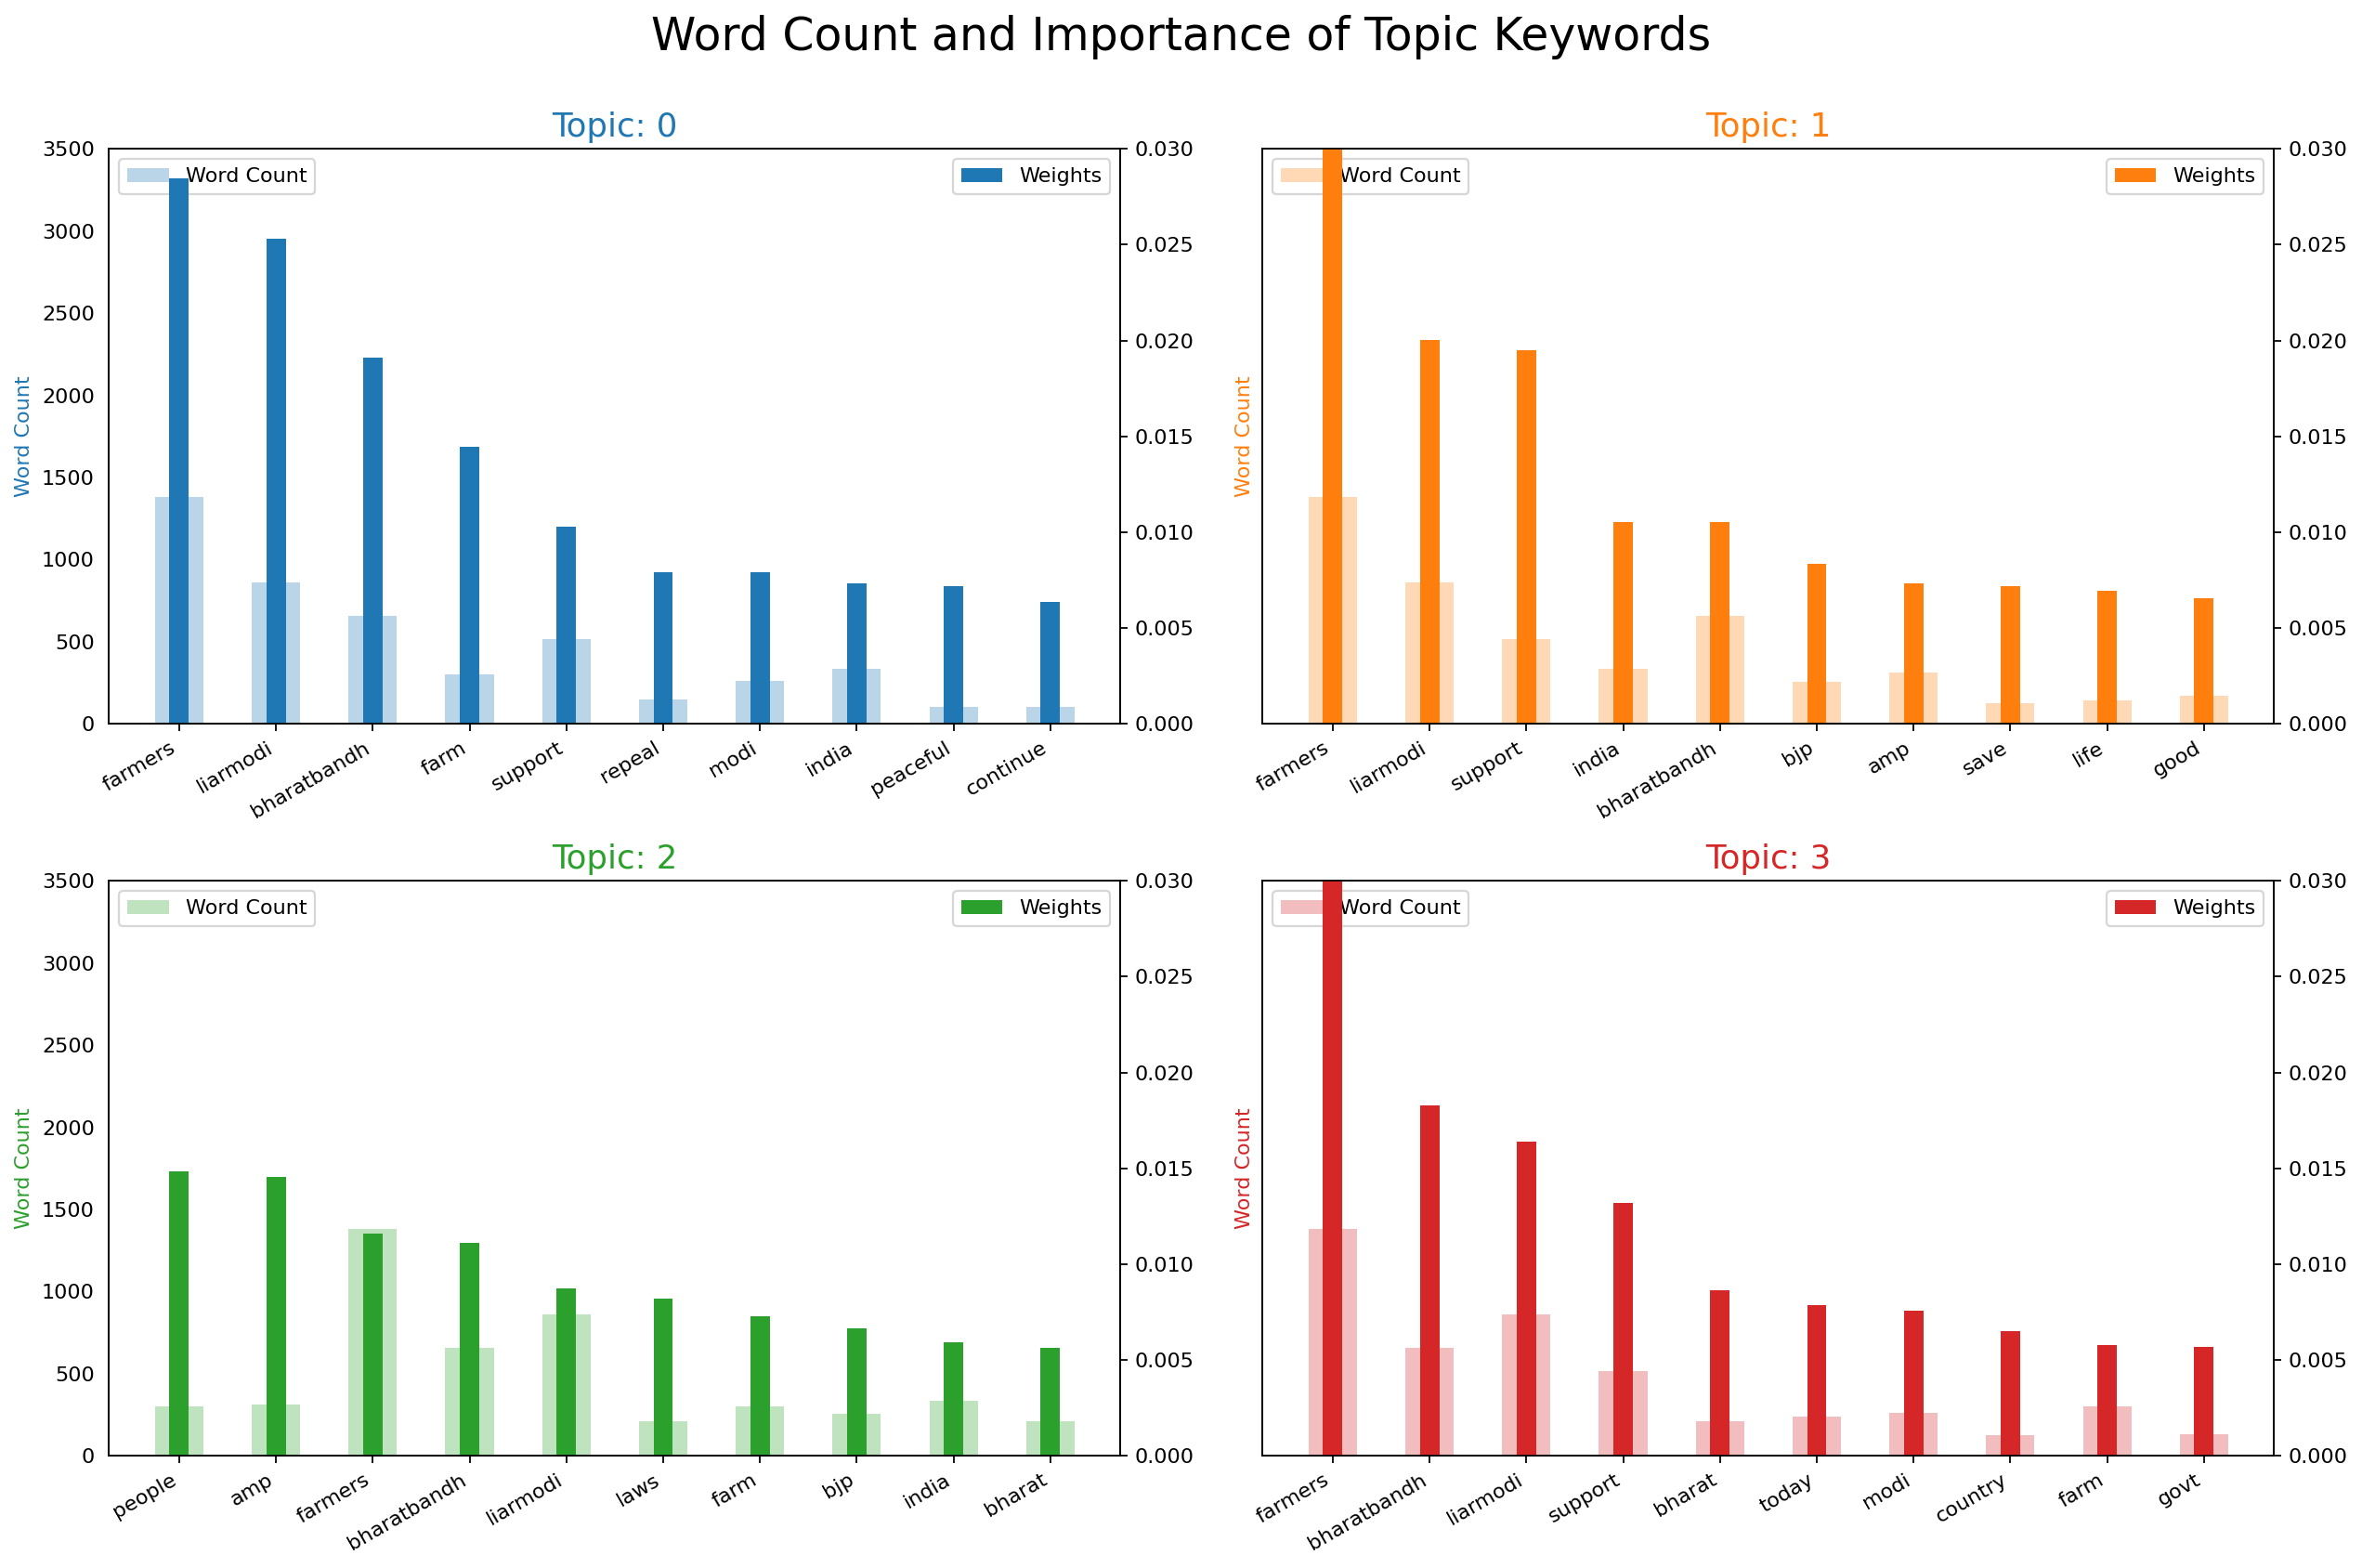

In [31]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    if i<len(topics):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    else:
        ax.set_visible(False)
        

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### t-distributed stochastic neighbor embedding Clustering Chart

In [32]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4079 samples in 0.004s...
[t-SNE] Computed neighbors for 4079 samples in 0.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4079
[t-SNE] Computed conditional probabilities for sample 2000 / 4079
[t-SNE] Computed conditional probabilities for sample 3000 / 4079
[t-SNE] Computed conditional probabilities for sample 4000 / 4079
[t-SNE] Computed conditional probabilities for sample 4079 / 4079
[t-SNE] Mean sigma: 0.000435
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.005020
[t-SNE] KL divergence after 1000 iterations: 0.262899


Loading BokehJS ...

In [33]:
import os
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./topic-modelled-'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './topic-modelled-'+ str(num_topics) +'.html')

LDAvis_prepared

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032158  0.027790       1        1  26.971979
1      0.027373  0.000864       2        1  23.576762
2      0.002085  0.067879       3        1  18.996003
0     -0.071086 -0.054194       4        1  18.521633
4      0.073786 -0.042338       5        1  11.933622, topic_info=         Term         Freq        Total Category  logprob  loglift
860  liarmodi   722.000000   722.000000  Default  30.0000  30.0000
89       farm   253.000000   253.000000  Default  29.0000  29.0000
62    farmers  1174.000000  1174.000000  Default  28.0000  28.0000
36     people   258.000000   258.000000  Default  27.0000  27.0000
182       amp   269.000000   269.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
473    farmer    11.640915   104.065966   Topic5  -5.9933  -0.0647
442      like    10.765372    75.427366   Topic5  -6.0715   0.1790
237    always    10.617977    75.100637   Topic5  -6.0853   0.1695
548      vote    10.645894   108.617783   Topic5  -6.0827  -0.1969
850      save    10.575341   106.296128   Topic5  -6.0893  -0.1819

[433 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6068      4  0.901945        ab
7158      1  0.783245     actor
6560      5  0.825986        ad
3051      1  0.879671   adamant
6909      3  0.778443   addicts
...     ...       ...       ...
510       3  0.100563     youth
510       4  0.201127     youth
510       5  0.351972     youth
436       4  0.353066  zindabad
436       5  0.529599  zindabad

[948 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5])

## Sentiment Analysis

In [ ]:

Topics = ['bjp', 'repeal', 'modi', 'farm laws']

for i in Topics:
    
    df = pd.read_csv('preprocessed_tweets.csv', quotechar='"', encoding='utf8')
    
    sub = i
    
    df['indexes'] = df['text_processed'].str.find(sub)
    
    # Get names of indexes which does not have the topic
    indexNames = df[ df['indexes'] == -1 ].index
    # Delete these row indexes from dataFrame
    df.drop(indexNames , inplace=True)
    #save for NER
    unique_tweets = df
    
    sid = SentimentIntensityAnalyzer()

    df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))

    df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
    df['sentiment_type']=''
    df.loc[df.compound>0,'sentiment_type']='POSITIVE'
    df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
    df.loc[df.compound<0,'sentiment_type']='NEGATIVE'
    
    fig, axes = plt.subplots(1, 1, figsize=(10,10), sharex=True, sharey=True)
   
    axes = df.sentiment_type.value_counts().plot.bar(title="sentiment analysis of "+i)
    
    print('\n' + i + 'Tweets \n')
    print(df.head())

## Named Entity Recognition

In [6]:
import spacy
import en_core_web_trf

In [11]:

Topics = ['bjp', 'repeal', 'modi', 'protest','farm laws']

for i in Topics:
    
    df = pd.read_csv('preprocessed_tweets.csv', quotechar='"', encoding='utf8')
    
    sub = i
    
    df['indexes'] = df['text_processed'].str.find(sub)
    
    # Get names of indexes which does not have the topic
    indexNames = df[ df['indexes'] == -1 ].index
    # Delete these row indexes from dataFrame
    df.drop(indexNames , inplace=True)
    #save for NER
    unique_tweets = df

unique_tweets_list = list(unique_tweets['text_processed'].values)

#Use a spacy model trained using our own dataset
nlp = spacy.load(r".\spacy_trained_model")


entities = list()

for tweet_text in unique_tweets_list:
  doc = nlp(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, ne.text,"--",tweet_text)
    entities.append(ne.text)

#print(entities)



A frustrated Rakesh Tikait says that he will commit Su c de if Govt doesnt take back the three farm laws 
A frustrated Rakesh Tikait says that he will commit Su c de if Govt doesnt take back the three farm laws 
A frustrated Rakesh Tikait says that he will commit Su c de if Govt doesnt take back the three farm laws 
A frustrated Rakesh Tikait says that he will commit Su c de if Govt doesnt take back the three farm laws 
 NE found:  18 24 B-per Holika -- Farmers celebrate Holika Dahan by burning copies of Centres farm laws
 NE found:  25 30 I-per Dahan -- Farmers celebrate Holika Dahan by burning copies of Centres farm laws
	NE found:  0 6 B-per Rakesh -- Rakesh Tikait burnt copies of the farm laws at Ghazipur border
	NE found:  7 13 I-per Tikait -- Rakesh Tikait burnt copies of the farm laws at Ghazipur border
	NE found:  47 55 B-geo Ghazipur -- Rakesh Tikait burnt copies of the farm laws at Ghazipur border
	NE found:  36 41 B-geo Delhi -- Farmers burn copies of farm laws at Delhi bord

	NE found:  193 194 B-org / -- This is the problem the laws to protect women and vulnerable people are always just talk not enough action and the 3 black farm laws will be the same they are only to help the rich/corporations/Modi friends
	NE found:  194 198 I-org Modi -- This is the problem the laws to protect women and vulnerable people are always just talk not enough action and the 3 black farm laws will be the same they are only to help the rich/corporations/Modi friends
	NE found:  0 7 B-org worrall -- worrall &amp the farm laws will be devastating 85% of Indians live below the poverty line Food security is in danger as laws now allow hoarding (previously banned for obvious reasons) r fighting corrupt gov &amp oligarchs to preserve democracy &amp human&amp labor rights
	NE found:  54 61 B-gpe Indians -- worrall &amp the farm laws will be devastating 85% of Indians live below the poverty line Food security is in danger as laws now allow hoarding (previously banned for obvious reason

	NE found:  111 117 B-geo Mysuru -- Farmer activists take out a mock funeral procession of the three controversial farm laws on BharatBandh day in Mysuru 
	NE found:  0 6 B-per Bharat -- Bharat Bandh against Privatisation of PSUs farm laws and fuel price hike All political parties except BJP took part in Telangana and Andhra BharatBandh
	NE found:  7 12 I-per Bandh -- Bharat Bandh against Privatisation of PSUs farm laws and fuel price hike All political parties except BJP took part in Telangana and Andhra BharatBandh
	NE found:  21 34 B-org Privatisation -- Bharat Bandh against Privatisation of PSUs farm laws and fuel price hike All political parties except BJP took part in Telangana and Andhra BharatBandh
	NE found:  102 105 B-org BJP -- Bharat Bandh against Privatisation of PSUs farm laws and fuel price hike All political parties except BJP took part in Telangana and Andhra BharatBandh
	NE found:  119 128 B-geo Telangana -- Bharat Bandh against Privatisation of PSUs farm laws and fue








	NE found:  0 3 B-tim 120 -- 120 days of day and night agitation against recently passed farm laws Farmers are mocked up continuously and are called terrorists Andolanjivi andcrowd are the new replacement of kisan Continues provocative and despotism is new Normal
	NE found:  131 142 B-per Andolanjivi -- 120 days of day and night agitation against recently passed farm laws Farmers are mocked up continuously and are called terrorists Andolanjivi andcrowd are the new replacement of kisan Continues provocative and despotism is new Normal
	NE found:  179 184 B-org kisan -- 120 days of day and night agitation against recently passed farm laws Farmers are mocked up continuously and are called terrorists Andolanjivi andcrowd are the new replacement of kisan Continues provocative and despotism is new Normal
 
 
 
